<a href="https://colab.research.google.com/github/M0n1ka-05/Topic-Modelling-on-news-article/blob/main/Monika_Shinde_Team_3_Capestone_Project_4_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

A Topic Model can be defined as an unsupervised technique to discover topics across various text documents. These topics are abstract in nature, i.e., words which are related to each other form a topic. Similarly, there can be multiple topics in an individual document.

It is a type of statistical model for discovering the abstract topics that occur in a collection of documents.

The objective of our project is to perform **topic modelling** on our dataset. Our dataset consist of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.

Our news dataset is having 5 different classes: 

*   Business
*   Entertainment
*   Politics
*   Sports
*   Technology

Importing all the basics libararies which we will require in the course of this project.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import ast

In [3]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

In [170]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We are having our dataset available in form of multiple text files. We are importing data using **glob** and **os** libraries. 

We will create dataframe containing news along with their respective labels.

In [42]:
base_dir = "/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/bbc/"
# read news
business_file_list = glob.glob(os.path.join(os.getcwd(), base_dir, "business", "*.txt"))
entertainment_file_list = glob.glob(os.path.join(os.getcwd(), base_dir, "entertainment", "*.txt"))
politics_file_list = glob.glob(os.path.join(os.getcwd(), base_dir, "politics", "*.txt"))
sport_file_list = glob.glob(os.path.join(os.getcwd(), base_dir, "sport", "*.txt"))
tech_file_list = glob.glob(os.path.join(os.getcwd(), base_dir, "tech", "*.txt"))

labels = []
corpus = []
for file_list in [
    business_file_list, entertainment_file_list, politics_file_list, sport_file_list, tech_file_list
]:
    for file_path in file_list:
        with open(file_path, encoding="utf8", errors='ignore') as f_input:
            corpus.append((f_input.read()))
            labels.append(file_path.split('/')[-2])

In [160]:
news_dict = {'news': corpus, 'news_typ': labels}

In [161]:
news_df = pd.DataFrame.from_dict(news_dict)

In [162]:
news_df.head(4)

,news,news_typ
0,Yukos unit buyer faces loan claim\n\nThe owner...,business
1,Ad sales boost Time Warner profit\n\nQuarterly...,business
2,Dollar gains on Greenspan speech\n\nThe dollar...,business
3,US trade gap hits record in 2004\n\nThe gap be...,business


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


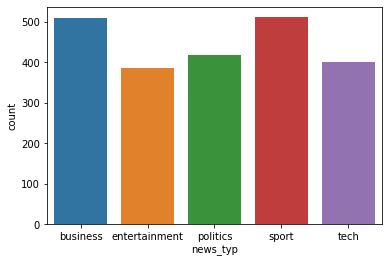

In [163]:
sns.countplot(news_df['news_typ'])

## **Data Preprocessing**

**Data preprocessing** is a fundamental step while building a machine learning model. If the data is fairly pre-processed the results would be reliable.
Let’s see the various different steps that are followed while preprocessing the data also used for dimensionality reduction.

It can be done by building a matrix that has documents for rows and a bag of words (list of all words from the corpus) for columns. That way defining a count of certain words in each document. To achieve a better performance will also clean the input data so that the maximum amount of information can be represented as the smallest matrix possible.

Below are few steps which we use as part of data preprocessing:

*  **Regular Expression/Normalization** — lowercase the words, remove punctuation and remove numbers
*  **Tokenization** — a process of splitting the text into smaller pieces called tokens
*  **Stop Words Removal** — a set of commonly used words in any language
*  **Lemmatization** — a process of grouping together the inflected forms of a word so they can be analyzed as a single item
*  **Stemming** — a process of grouping together the inflected forms of a word so they can be analyzed as a single item

**Regular Expression/Normalization**

We are removing unneccesary number and punctuations , as we don't require them in our modelling.

In [164]:
# removing everything except alphabets`
news_df['news'] = news_df['news'].str.replace("[^a-zA-Z#]", " ")


In [165]:
# removing short words
news_df['news'] = news_df['news'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

In [166]:
#function to remove punctuation
def rmv_punctuation(text):
    return ''.join(s for s in text if s not in punctuation)

In [167]:
news_df['news'] = news_df['news'].apply(rmv_punctuation)


**Tokenization** 

Tokenization is the process by which big quantity of text is divided into smaller parts called tokens.

In [173]:
news_df['tokenized_news'] = news_df.apply(lambda row: nltk.word_tokenize(row['news']), axis=1)

**Stop Words Removal**

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.

We are using **NLTK** to remove stopwords.

In [172]:
nltk.download('stopwords')

# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [257]:
type(sw)

list

In [183]:
def rmv_stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    return [word.lower() for word in text.split() if word.lower() not in sw]

In [207]:
news_df['tokenized_news'] = news_df['news'].apply(rmv_stopwords)
news_df.head(10)

,news,news_typ,tokenized_news,num_tokens
0,Yukos unit buyer faces loan claim The owners e...,business,"[yukos, unit, buyer, faces, loan, claim, owner...",1120
1,sales boost Time Warner profit Quarterly profi...,business,"[sales, boost, time, warner, profit, quarterly...",1866
2,Dollar gains Greenspan speech The dollar has h...,business,"[dollar, gains, greenspan, speech, dollar, hit...",1623
3,trade gap hits record The gap between exports ...,business,"[trade, gap, hits, record, gap, exports, impor...",1422
4,High fuel prices hit profits British Airways h...,business,"[high, fuel, prices, hit, profits, british, ai...",1814
5,India widens access telecoms India has raised ...,business,"[india, widens, access, telecoms, india, raise...",1305
6,Yukos loses bankruptcy battle judge has dismis...,business,"[yukos, loses, bankruptcy, battle, judge, dism...",1919
7,Ask Jeeves tips online revival Ask Jeeves has ...,business,"[ask, jeeves, tips, online, revival, ask, jeev...",825
8,Indonesians face fuel price rise Indonesia gov...,business,"[indonesians, face, fuel, price, rise, indones...",1385
9,Telegraph newspapers axe jobs The Daily and Su...,business,"[telegraph, newspapers, axe, jobs, daily, sund...",2215


In [208]:
news_df.shape

(2225, 4)

**Lemmetization**

Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.


Python NLTK provides **WordNet Lemmatizer** that uses the WordNet Database to lookup lemmas of words.

In [209]:
#lemmetization
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text])

In [210]:
news_df['tokenized_news'] = news_df['tokenized_news'].apply(lemmatize_text)

In [211]:
news_df.head(5)

,news,news_typ,tokenized_news,num_tokens
0,Yukos unit buyer faces loan claim The owners e...,business,yukos unit buyer face loan claim owner embattl...,1120
1,sales boost Time Warner profit Quarterly profi...,business,sale boost time warner profit quarterly profit...,1866
2,Dollar gains Greenspan speech The dollar has h...,business,dollar gain greenspan speech dollar hit highes...,1623
3,trade gap hits record The gap between exports ...,business,trade gap hit record gap export import hit tim...,1422
4,High fuel prices hit profits British Airways h...,business,high fuel price hit profit british airway blam...,1814


As we have processed out data, now let's have look on number of tokens we have in each document.



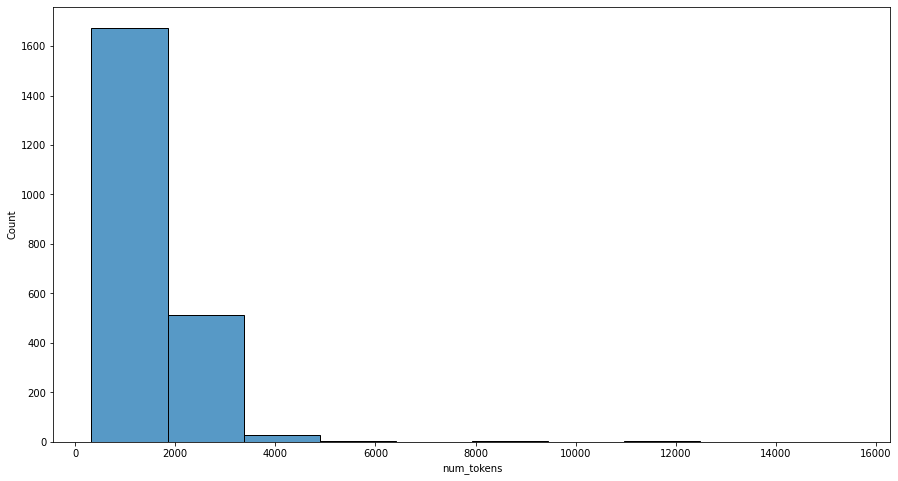

In [213]:
# Sum the number of tokens in each Doc
news_df['num_tokens'] = [len(token) for token in news_df.tokenized_news]
# Visualize histogram of tokens per tweet
plt.figure(figsize=(15,8))
g = sns.histplot(new_df.num_tokens, bins = 10)

In [214]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

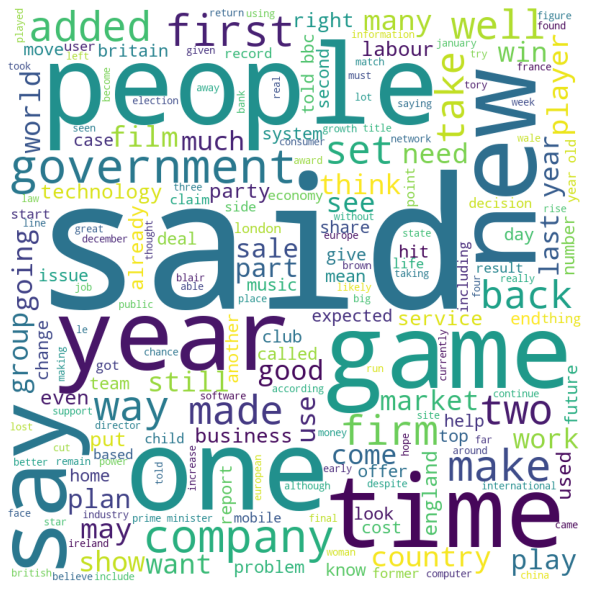

In [215]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in news_df.tokenized_news: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [216]:
news_data = news_df['tokenized_news']

In [217]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_news = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_news, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_news.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [218]:
news_data.values

array(['yukos unit buyer face loan claim owner embattled russian oil giant yukos ask buyer former production unit pay back loan state owned rosneft bought yugansk unit sale forced russia part settle tax claim yukos yukos owner menatep group say ask rosneft repay loan yugansk secured asset rosneft already face similar repayment demand foreign bank legal expert said rosneft purchase yugansk would include obligation pledged asset rosneft pay real money creditor avoid seizure yugansk asset said moscow based lawyer jamie firestone connected case menatep group managing director tim osborne told reuters news agency default fight rule law exists international arbitration clause credit rosneft official unavailable comment company said intends take action menatep recover tax claim debt owed yugansk yukos filed bankruptcy protection court attempt prevent forced sale main production arm sale went ahead december yugansk sold little known shell company turn bought rosneft yukos claim downfall punish

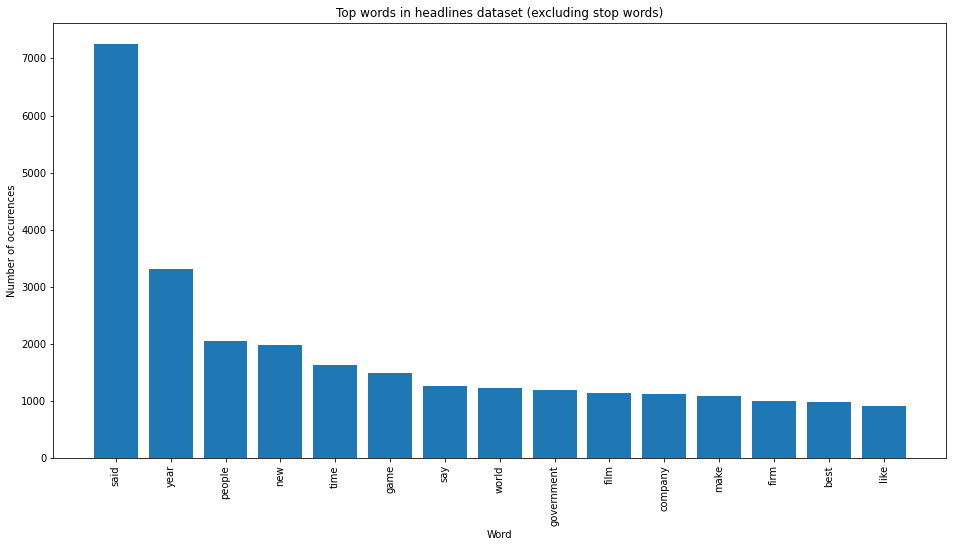

In [220]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=news_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [221]:
news_df.head(6)

,news,news_typ,tokenized_news,num_tokens
0,Yukos unit buyer faces loan claim The owners e...,business,yukos unit buyer face loan claim owner embattl...,1071
1,sales boost Time Warner profit Quarterly profi...,business,sale boost time warner profit quarterly profit...,1709
2,Dollar gains Greenspan speech The dollar has h...,business,dollar gain greenspan speech dollar hit highes...,1529
3,trade gap hits record The gap between exports ...,business,trade gap hit record gap export import hit tim...,1263
4,High fuel prices hit profits British Airways h...,business,high fuel price hit profit british airway blam...,1620
5,India widens access telecoms India has raised ...,business,india widens access telecom india raised limit...,1235


In [222]:
vectors = count_vectorizer.fit_transform(news_data)
feature_names = count_vectorizer.get_feature_names()

print(feature_names)

['aaa', 'aac', 'aadc', 'aaliyah', 'aaltra', 'aamir', 'aan', 'aara', 'aarhus', 'aaron', 'abacus', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abate', 'abatement', 'abating', 'abba', 'abbas', 'abbasi', 'abbey', 'abbot', 'abbott', 'abbreviated', 'abc', 'abd', 'abdellatif', 'abdication', 'abdomen', 'abdominal', 'abducted', 'abduction', 'abdul', 'abdullah', 'abdullatif', 'abebe', 'abensur', 'aberavon', 'aberdeen', 'aberration', 'aberystwyth', 'abetting', 'abeyance', 'abeyie', 'abhorrent', 'abi', 'abide', 'abided', 'abiding', 'abigail', 'ability', 'abish', 'abiyote', 'able', 'abn', 'abnormal', 'abnormality', 'abolish', 'abolished', 'abolishing', 'abolition', 'aborted', 'abortion', 'abortionist', 'abortive', 'aboutroughly', 'abraham', 'abramovich', 'abroad', 'abrupt', 'abruptly', 'absa', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absolution', 'absorb', 'absorbed', 'absorbing', 'absorbs', 'abstain', 'abstention', 'abstract', 'absurd', 'abtahi', 'abu', 'abundance', 'a

In [223]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(vectors)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(vectors))



Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -882484.7608548596
LDA model Perplexity on train data 3728.3013084482986


In [225]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [226]:
!pip install pyLDAvis

In [227]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [228]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, vectors,count_vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  24.265037
2       51.163364 -159.968018       2        1  23.856204
1      -73.144554   21.523815       3        1  18.199538
0      -66.410133 -110.606438       4        1  17.722933
3       54.417324   12.443444       5        1  15.956289, topic_info=           Term         Freq        Total Category  logprob  loglift
8058       film  1068.000000  1068.000000  Default  30.0000  30.0000
8756       game  1410.000000  1410.000000  Default  29.0000  29.0000
12188    labour   771.000000   771.000000  Default  28.0000  28.0000
6886   election   725.000000   725.000000  Default  27.0000  27.0000
1498      award   564.000000   564.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
19448       set   241.428318   769.040957   Topic5  -5.6443   0.6767
15161       old   206.187763   473.321361   Topic5  -5.8021   1.0043
14718       new   241.016147  1872.359997   Topic5  -5.6460  -0.2148
21839     think   204.418267   615.854897   Topic5  -5.8107   0.7325
23687      week   201.648435   761.348635   Topic5  -5.8243   0.5068

[374 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
104        3  0.952329  academy
104        5  0.037104  academy
231        3  0.998239    actor
232        3  0.997804  actress
479        1  0.048984      aid
...      ...       ...      ...
24221      3  0.259134     year
24221      4  0.319279     year
24221      5  0.152601     year
24274      4  0.963464     yuan
24286      2  0.995154    yukos

[804 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

In [260]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.05, 
                                 use_idf=True, 
                                  lowercase=True)

In [262]:
tfidf_matrix = tfidf_vectorizer.fit_transform(news_data);

In [263]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix);

In [264]:
for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['economy', 'growth', 'price', 'sale', 'bank', 'share', 'year', 'market', 'firm', 'company']


Topic #1:
['digital', 'site', 'service', 'software', 'computer', 'user', 'phone', 'technology', 'people', 'mobile']


Topic #2:
['people', 'brown', 'tory', 'minister', 'would', 'blair', 'government', 'party', 'election', 'labour']


Topic #3:
['time', 'star', 'win', 'player', 'first', 'award', 'best', 'year', 'game', 'film']


Topic #4:
['trial', 'production', 'financial', 'career', 'winning', 'internet', 'played', 'fourth', 'version', 'release']




In [276]:
lda_panel = pyLDAvis.sklearn.prepare(lda, tfidf_matrix,tfidf_vectorizer)
lda_panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.113559  0.023694       1        1  36.890299
0      0.076382 -0.029694       2        1  21.828025
2     -0.001745 -0.089180       3        1  20.898303
1      0.050354  0.095349       4        1  17.641522
4     -0.011431 -0.000168       5        1   2.741851, topic_info=         Term       Freq      Total Category  logprob  loglift
277    labour  44.000000  44.000000  Default  30.0000  30.0000
158  election  43.000000  43.000000  Default  29.0000  29.0000
343    mobile  34.000000  34.000000  Default  28.0000  28.0000
60      blair  37.000000  37.000000  Default  27.0000  27.0000
386     party  43.000000  43.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
279   largest   0.631751  14.103543   Topic5  -6.4060   0.4909
575      vote   0.631721  19.057715   Topic5  -6.4061   0.1898
456    robert   0.631716  13.776982   Topic5  -6.4061   0.5142
468  scotland   0.631708  21.816105   Topic5  -6.4061   0.0546
186      fell   0.631707  14.355011   Topic5  -6.4061   0.4731

[264 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         2  0.116581  access
1         3  0.174872  access
1         4  0.641197  access
1         5  0.058291  access
8         1  0.944235   actor
...     ...       ...     ...
602       5  0.009691    year
605       1  0.597456   young
605       3  0.298728   young
605       4  0.059746   young
605       5  0.059746   young

[849 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

### **LSA**

### Latent Semantic Analysis (LSA) is a theory and method for extracting and representing the contextual-usage meaning of words by statistical computations applied to a large corpus of text.

### LSA itself is an unsupervised way of uncovering synonyms in a collection of documents.

In [235]:
news_df.head(3)

,news,news_typ,tokenized_news,num_tokens
0,Yukos unit buyer faces loan claim The owners e...,business,yukos unit buyer face loan claim owner embattl...,1071
1,sales boost Time Warner profit Quarterly profi...,business,sale boost time warner profit quarterly profit...,1709
2,Dollar gains Greenspan speech The dollar has h...,business,dollar gain greenspan speech dollar hit highes...,1529


using TF-IDF vectorizer

In [266]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.05, 
                                 use_idf=True, 
                                  lowercase=True)

X = vectorizer.fit_transform(news_data)

X.shape # check shape of the document-term matrix

(2225, 606)

Used K-Means just for plotting purpose.

In [270]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_.tolist()

In [267]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

5

In [268]:
svd_model.get_params

<bound method BaseEstimator.get_params of TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=122, tol=0.0)>

In [269]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
year
 
would
 
game
 
people
 
new
 
film
 
also
 
Topic 1: 
film
 
game
 
award
 
best
 
win
 
star
 
player
 
Topic 2: 
film
 
award
 
best
 
actor
 
company
 
director
 
movie
 
Topic 3: 
film
 
labour
 
election
 
blair
 
party
 
award
 
tory
 
Topic 4: 
mobile
 
phone
 
people
 
technology
 
user
 
software
 
computer
 


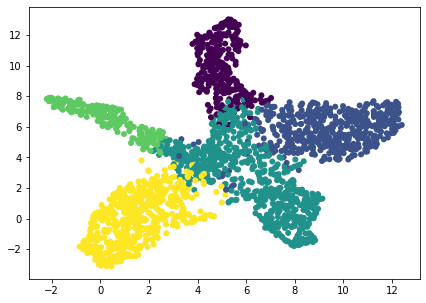

In [273]:
import umap
X_topics=svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = clusters,
edgecolor='none'
)
plt.show()

### **LDA using Geneism**

In [277]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [279]:
data = news_df.news.to_list()

In [282]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [284]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['yukos', 'unit', 'buyer', 'faces', 'loan', 'claim', 'the', 'owners', 'embattled', 'russian_oil', 'giant', 'yukos', 'are', 'ask', 'the', 'buyer', 'its', 'former', 'production_unit', 'pay', 'back', 'loan', 'state_owned', 'rosneft', 'bought', 'the', 'yugansk', 'unit', 'for', 'sale', 'forced', 'russia', 'part', 'settle', 'tax', 'claim', 'against', 'yukos', 'yukos', 'owner', 'menatep', 'group', 'says', 'will', 'ask', 'rosneft', 'repay', 'loan', 'that', 'yugansk', 'had', 'secured', 'its', 'assets', 'rosneft', 'already', 'faces', 'similar', 'repayment', 'demand', 'from', 'foreign', 'banks', 'legal', 'experts', 'said', 'rosneft', 'purchase', 'yugansk', 'would', 'include', 'such', 'obligations', 'the', 'pledged', 'assets', 'are', 'with', 'rosneft', 'will', 'have', 'pay', 'real', 'money', 'the', 'creditors', 'avoid', 'seizure', 'yugansk', 'assets', 'said', 'moscow', 'based', 'lawyer', 'jamie', 'firestone', 'who', 'not', 'connected', 'the', 'case', 'menatep', 'group', 'managing_director', 'tim',

In [289]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in sw] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [290]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [291]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 3), (7, 1), (8, 1), (9, 1), (10, 2), (11, 4), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 5), (62, 1), (63, 1), (64, 4), (65, 4), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 6)]]


In [297]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           alpha='auto',
                                           per_word_topics=True)

In [298]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.106496843508165

Coherence Score:  0.39477680813246674


In [303]:
lda_panel = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
lda_panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.029913 -0.066332       1        1  34.478059
0     -0.121756  0.130624       2        1  23.563343
4      0.178381  0.049294       3        1  17.960500
1     -0.012010  0.010079       4        1  12.355652
3     -0.074528 -0.123665       5        1  11.642447, topic_info=          Term         Freq        Total Category  logprob  loglift
732       game  2421.000000  2421.000000  Default  30.0000  30.0000
2739  software   885.000000   885.000000  Default  29.0000  29.0000
450     mobile  1431.000000  1431.000000  Default  28.0000  28.0000
566     player  1486.000000  1486.000000  Default  27.0000  27.0000
1348     phone  1187.000000  1187.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
416      start   131.465361   765.054577   Topic5  -5.7066   0.3893
117       firm   140.735879  1232.053072   Topic5  -5.6384  -0.0190
242       make   153.958868  2395.198785   Topic5  -5.5486  -0.5940
318       give   132.322063   946.766609   Topic5  -5.7001   0.1827
1449      team   119.907367   473.364471   Topic5  -5.7986   0.7774

[418 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1777      1  0.751506    able
1777      2  0.137736    able
1777      4  0.072493    able
1777      5  0.038663    able
423       1  0.528101  access
...     ...       ...     ...
195       1  0.130817    year
195       2  0.506728    year
195       3  0.153873    year
195       4  0.088214    year
195       5  0.120291    year

[1009 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])